## Download the data

We first need to load the data from the ProPublica repo:
https://github.com/propublica/compas-analysis


# Course Project

## Dataset

You will examine the ProPublica COMPAS dataset, which consists of all criminal defendants who were subject to COMPAS screening in Broward County, Florida, during 2013 and 2014. For each defendant, various information fields (‘features’) were also gathered by ProPublica. Broadly, these fields are related to the defendant’s demographic information (e.g., gender and race), criminal history (e.g., the number of prior offenses) and administrative information about the case (e.g., the case number, arrest date, risk of recidivism predicted by the COMPAS tool). Finally, the dataset also contains information about whether the defendant did actually recidivate or not.

The COMPAS score uses answers to 137 questions to assign a risk score to defendants -- essentially a probability of re-arrest. The actual output is two-fold: a risk rating of 1-10 and a "low", "medium", or "high" risk label.

Link to dataset: https://github.com/propublica/compas-analysis

The file we will analyze is: compas-scores-two-years.csv

Link to the ProPublica article:

https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing


## Project goal

The project has three parts: 

- The COMPAS scores have been shown to have biases against certain racial groups. Analyze the dataset to highlight these biases.  

- Based on the features in the COMPAS dataset, train classifiers to predict who will re-offend (hint: no need to use all features, just the ones you find relevant).  Study if your classifiers are more or less fair than the COMPAS classifier. 

- Build a fair classifier (last lecture will cover fair classification techniques). Is excluding the race from the feature set enough?


## Today

Explore the dataset and do some initial statistics. 

In [41]:
import urllib
import os, sys, torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
import torch.utils.data as dt 

from pylab import rcParams

from sklearn import feature_extraction
from sklearn import preprocessing
from random import seed, shuffle
from datetime import datetime
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

In [1]:
SEED = 1234
seed(SEED)
np.random.seed(SEED)

def check_data_file(fname):
    files = os.listdir(".") # get the current directory listing
    print("Looking for file '%s' in the current directory...",fname)

    if fname not in files:
        print("'%s' not found! Downloading from GitHub...",fname)
        addr = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
        response = urllib.request.urlopen(addr)
        data = response.read()
        fileOut = open(fname, "wb")
        fileOut.write(data)
        fileOut.close()
        print("'%s' download and saved locally..",fname)
    else:
        print("File found in current directory..")

    
COMPAS_INPUT_FILE = "compas-scores-two-years.csv"
check_data_file(COMPAS_INPUT_FILE)

table = pd.read_csv('compas-scores-two-years.csv',delimiter = ',')
#print(table.isnull())#is null checks missing values in a table, return a table of boolean

df = pd.read_csv(COMPAS_INPUT_FILE)   #df is a dataframe
print(df.keys())





df = df.dropna(subset=["days_b_screening_arrest"]) # dropping missing vals (NaN for sure, also null???)

df = df[
    (df.days_b_screening_arrest <= 30) &  
    (df.days_b_screening_arrest >= -30) &  
    (df.is_recid != -1) &
    (df.c_charge_degree != 'O') &
    (df.score_text != 'N/A')
]    # Only keep the values that forfull these constraints

df.reset_index(inplace=True, drop=True) # renumber the rows from 0 again
print(df)
print(df.shape)

print(df.race.drop_duplicates())
print(df.age_cat.drop_duplicates())





Looking for file '%s' in the current directory... compas-scores-two-years.csv
File found in current directory..
Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'st

In [2]:
df[['decile_score','score_text']]

,decile_score,score_text
0,1,Low
1,3,Low
2,4,Low
3,1,Low
4,6,Medium
...,...,...
6167,7,Medium
6168,3,Low
6169,1,Low
6170,2,Low


## Load data and clean it up

__Load the data__

hint: data is in csv format; pandas is a python library that can read csv files

you can choose to represent your data either as a DataFrame or as a dictionary

- The dataset contains data on how many convicts? 

- What are the features the dataset contains?

hint pandas: check pandas functions shape, column, head

hint dictionary: check keys() function

In [3]:
df = pd.read_csv(COMPAS_INPUT_FILE)   #df is a dataframe

print("shape: " + str(df.shape))   # Tuple representing the dimensionality
print("index (the amount of convict = 7214) : " + str(df.index))   # The index (row labels) of the DataFrame.
print("Different features of the convicts (53): " + str(df.columns))
print("Different features of the convicts (53): " + str(df.keys())) # we can also use keys()
print("index.value_counts (???): " + str(df['race'].value_counts())) # count the unique values in a column
print("Display the first 3 rowns:" + str(df.head(5)))

table = pd.read_csv('compas-scores-two-years.csv',delimiter = ',')
print(table.isnull())#is null checks missing values in a table, return a table of boolean




shape: (7214, 53)
index (the amount of convict = 7214) : RangeIndex(start=0, stop=7214, step=1)
Different features of the convicts (53): Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'pr

__Cleanup the data__

- Are there missing values (NaN)? are there outliers?  

hint pandas: check isnull function in pandas

hint dictionary: implement a for and check if the variable is None

- Does ProPublica mentions how to clean the data?
 -> YES

__What is the effect of the following function?__

df = pd.read_csv(COMPAS_INPUT_FILE)

print(df.shape)

df = df.dropna(subset=["days_b_screening_arrest"]) # dropping missing vals

df = df[
    (df.days_b_screening_arrest <= 30) &  
    (df.days_b_screening_arrest >= -30) &  
    (df.is_recid != -1) &
    (df.c_charge_degree != 'O') &
    (df.score_text != 'N/A')
]

df.reset_index(inplace=True, drop=True) # renumber the rows from 0 again

## Basic analysis of demographics

- What are the different races present in the dataset? 

In [4]:
print(df.race.drop_duplicates().values)

['Other' 'African-American' 'Caucasian' 'Hispanic' 'Native American'
 'Asian']


- What is the number of people by age category?

In [5]:
print("number of people by age category: \n" + str(df['age_cat'].value_counts())) # count the unique values in a column

number of people by age category: 
25 - 45            4109
Greater than 45    1576
Less than 25       1529
Name: age_cat, dtype: int64


- What is the number of people by race?

In [6]:
print("number of people by race: \n" + str(df['race'].value_counts())) # count the unique values in a column

number of people by race: 
African-American    3696
Caucasian           2454
Hispanic             637
Other                377
Asian                 32
Native American       18
Name: race, dtype: int64


- What is the number of people by COMPAS score (decile_score)?

In [7]:
print("number of people by COMPAS score: \n" + str(df['decile_score'].value_counts())) # count the unique values in a column

number of people by COMPAS score: 
1     1440
2      941
4      769
3      747
5      681
6      641
7      592
8      512
9      508
10     383
Name: decile_score, dtype: int64


- What is the number of people by COMPAS risk category (score_text)?

In [8]:
print("number of people by COMPAS risk category: \n" + str(df['score_text'].value_counts())) # count the unique values in a column

number of people by COMPAS risk category: 
Low       3897
Medium    1914
High      1403
Name: score_text, dtype: int64


## Basic investigations of gender and race bias in COMPAS scores

decile_score -- is the score given by the COMPAS algorithm that estimates the risk to re-offend.

score_text -- is the level of risk: Low, Medium, High

two_years_recid -- is the ground truth data on whether the offender recidivated or not

- What is the mean COMPAS score (decile_score) per race and gender? 

In [9]:
tab = df[['decile_score','race','sex']]
stat = tab.groupby(['race', 'sex'])  


for key, item in stat:
    print(key, "\n")
    print(stat.get_group(key).mean(), "\n\n")
    print("number per group:",stat.get_group(key).count()['decile_score'], "\n\n")

('African-American', 'Female') 

decile_score    4.757669
dtype: float64 


number per group: 652 


('African-American', 'Male') 

decile_score    5.499671
dtype: float64 


number per group: 3044 


('Asian', 'Female') 

decile_score    2.0
dtype: float64 


number per group: 2 


('Asian', 'Male') 

decile_score    3.0
dtype: float64 


number per group: 30 


('Caucasian', 'Female') 

decile_score    3.897707
dtype: float64 


number per group: 567 


('Caucasian', 'Male') 

decile_score    3.686275
dtype: float64 


number per group: 1887 


('Hispanic', 'Female') 

decile_score    2.883495
dtype: float64 


number per group: 103 


('Hispanic', 'Male') 

decile_score    3.574906
dtype: float64 


number per group: 534 


('Native American', 'Female') 

decile_score    6.5
dtype: float64 


number per group: 4 


('Native American', 'Male') 

decile_score    6.071429
dtype: float64 


number per group: 14 


('Other', 'Female') 

decile_score    2.701493
dtype: float64 


number p

- What is the distribution (histogram) of decile_score per race and gender? 

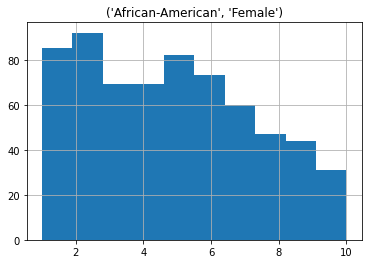

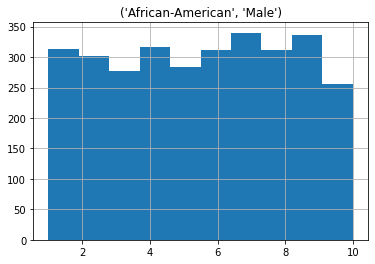

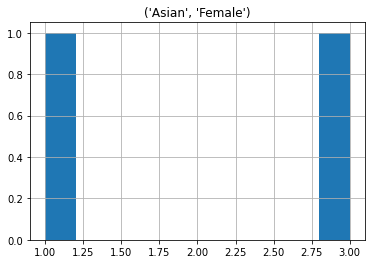

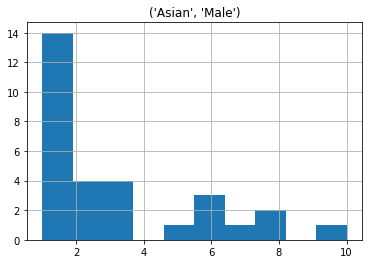

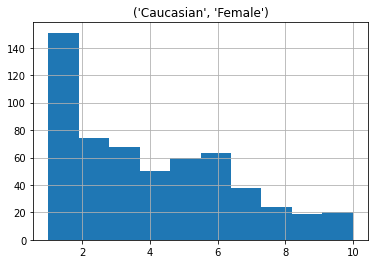

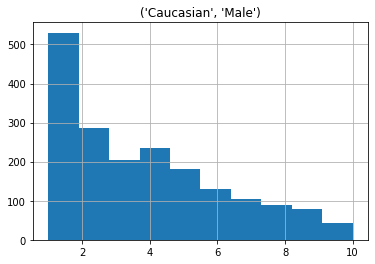

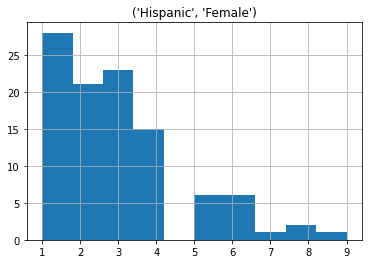

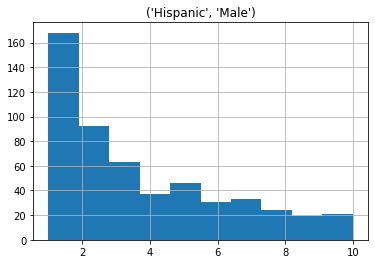

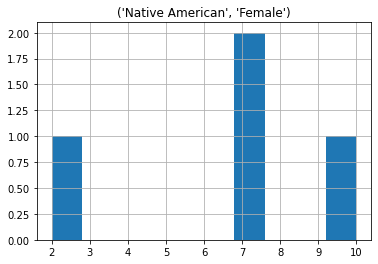

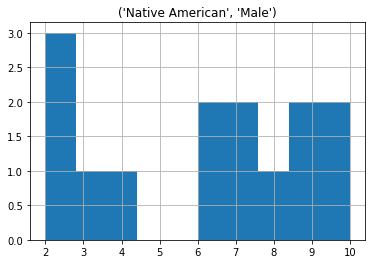

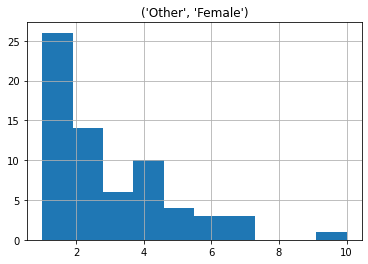

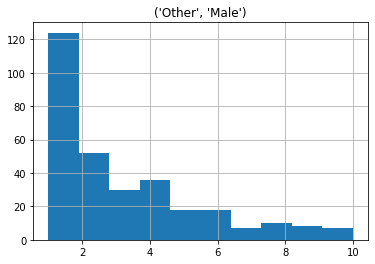

In [10]:
labels=list(stat.groups.keys())


for key, item in stat:
    stat.get_group(key).hist(bins=10)
    plt.title(key)



#stat['decile_score'].hist(bins=10, label=labels)


We can see there that in pretty much all groupes we have a large portion of people were assigned a low score and only a few had been assigned a high score excapet in the group *'African-American', 'Male'*. In this group we have a near equal distribution of scores.

The two_year_recid field records whether or not each person was re-arrested for a violent offense within two years, which is what COMPAS is trying to predict.

- How many people were re-arrested? 

In [11]:
df_rearrest = df[df.two_year_recid==1]
df_rearrest = df_rearrest[['decile_score','race','sex']]
print("number of people were re-arrested:",df_rearrest['decile_score'].shape[0])

number of people were re-arrested: 3251


- Compute the recidivism (i.e., people that got re-arrested) rates by race and gender

In [12]:
df_rearrest_bycat = df_rearrest.groupby(['race', 'sex'])  

for key, item in stat:
    print(key, "\n")
    #print(df_rearrest_bycat.get_group(key).mean(), "\n\n")
    print("number per group:",df_rearrest_bycat.get_group(key).count()['race'],"\n")
    print("recidivism rate:",df_rearrest_bycat.get_group(key).count()['race']/stat.get_group(key).count()['race'], "\n\n")

('African-American', 'Female') 

number per group: 247 

recidivism rate: 0.37883435582822084 


('African-American', 'Male') 

number per group: 1654 

recidivism rate: 0.5433639947437582 


('Asian', 'Female') 

number per group: 1 

recidivism rate: 0.5 


('Asian', 'Male') 

number per group: 8 

recidivism rate: 0.26666666666666666 


('Caucasian', 'Female') 

number per group: 199 

recidivism rate: 0.3509700176366843 


('Caucasian', 'Male') 

number per group: 767 

recidivism rate: 0.40646528881823 


('Hispanic', 'Female') 

number per group: 33 

recidivism rate: 0.32038834951456313 


('Hispanic', 'Male') 

number per group: 199 

recidivism rate: 0.37265917602996257 


('Native American', 'Female') 

number per group: 3 

recidivism rate: 0.75 


('Native American', 'Male') 

number per group: 7 

recidivism rate: 0.5 


('Other', 'Female') 

number per group: 15 

recidivism rate: 0.22388059701492538 


('Other', 'Male') 

number per group: 118 

recidivism rate: 0.380645

- What is the accuracy of the COMPAS scores to predict recidivism

We calculated the accuracy using the same way *ProPulica* used. That is, if a person is categorised as *Medium* or *High* as score category, it's counted as a positive prediction. A person in *Low* category is a negative prediction.

In [13]:
tab = df[['score_text','race','sex','two_year_recid']]
stat = tab.groupby(['race', 'sex'])  

df_rearrest = df[df.two_year_recid==1]
df_rearrest = df_rearrest[['score_text','race','sex']]



In [14]:
accurecy = tab[(((df.score_text=='High') | (df.score_text=='Medium')) & (df.two_year_recid==1)) | ((df.score_text=='Low') & (df.two_year_recid==0))].count()['score_text']/tab.count()['score_text']
print("global accurecy", accurecy)

global accurecy 0.6537288605489326


We can see here the accurecy is not high at all.

- Is the accuracy higher/lower if we look at particular races/genders?

('African-American', 'Female') 
 0.6349693251533742 


('African-American', 'Male') 
 0.6389618922470434 


('Asian', 'Female') 
 0.5 


('Asian', 'Male') 
 0.8666666666666667 


('Caucasian', 'Female') 
 0.6525573192239859 


('Caucasian', 'Male') 
 0.6751457339692634 


('Hispanic', 'Female') 
 0.6990291262135923 


('Hispanic', 'Male') 
 0.653558052434457 


('Native American', 'Female') 
 1.0 


('Native American', 'Male') 
 0.7142857142857143 


('Other', 'Female') 
 0.7611940298507462 


('Other', 'Male') 
 0.6451612903225806 




/home/simon_rober/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Text(0.5, 1.0, 'Accurecy per group')

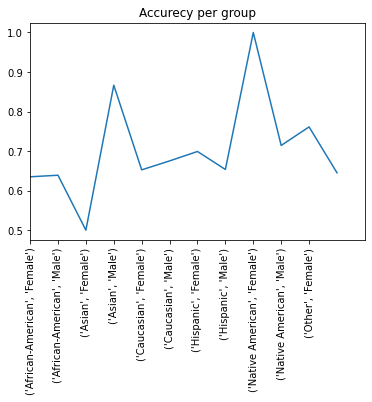

In [15]:
keys=[]
acc_list=[]
for key, item in stat:
    keys.append(key)
    stat_group=stat.get_group(key)
    TPredic=stat_group[(((df.score_text=='High') | (df.score_text=='Medium')) & (stat_group.two_year_recid==1)) | ((stat_group.score_text=='Low') & (stat_group.two_year_recid==0))].count()['score_text']
    Predic=stat_group.count()['score_text']
    if TPredic==0 :
        accurecy = 0
    else:
        accurecy=TPredic/Predic
    print(key,'\n',accurecy, '\n\n')
    acc_list.append(accurecy)

plt.plot(acc_list)
plt.xlim(0,12)
plt.xticks(range(0, 11),keys,rotation=90)
plt.title("Accurecy per group")




As we can see in the graph, the accuracy is not homogeneous among races and genders. The model has a poorer performance for the race *African-American* than *Caucasian*.

- What about false positives and false negatives?

('African-American', 'Female') 
 0.486646884272997 


('African-American', 'Male') 
 0.34893848666303756 


('Asian', 'Female') 
 0 


('Asian', 'Male') 
 0.25 


('Caucasian', 'Female') 
 0.4955357142857143 


('Caucasian', 'Male') 
 0.37777777777777777 


('Hispanic', 'Female') 
 0.4375 


('Hispanic', 'Male') 
 0.45977011494252873 


('Native American', 'Female') 
 0 


('Native American', 'Male') 
 0.3333333333333333 


('Other', 'Female') 
 0.5454545454545454 


('Other', 'Male') 
 0.4411764705882353 




/home/simon_rober/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/simon_rober/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


Text(0.5, 1.0, 'False Positive rate per group')

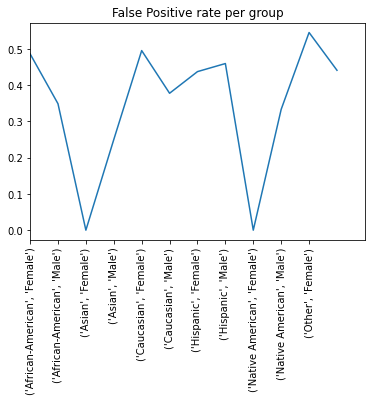

In [16]:
keys=[]
acc_list=[]
for key, item in stat:
    keys.append(key)
    stat_group=stat.get_group(key)
    FPos=stat_group[(((df.score_text=='High') | (df.score_text=='Medium')) & (stat_group.two_year_recid==0))].count()['score_text']
    Pos=stat_group[((df.score_text=='High') | (df.score_text=='Medium'))].count()['score_text']
    if FPos==0 :
        accurecy = 0
    else:
        accurecy=FPos/Pos
    print(key,'\n',accurecy, '\n\n')
    acc_list.append(accurecy)

plt.plot(acc_list)
plt.xlim(0,12)
plt.xticks(range(0, 11),keys,rotation=90)
plt.title("False Positive rate per group")



Here except 2 groups *'Asian', 'Female'* and *'Native American', 'Female'* where the model didn't make any positive prediction, We can see that the false positive rates are still different between races and genders.

('African-American', 'Female') 
 0.13649851632047477 


('African-American', 'Male') 
 0.12955906369080022 


('Asian', 'Female') 
 0 


('Asian', 'Male') 
 0.125 


('Caucasian', 'Female') 
 0.11160714285714286 


('Caucasian', 'Male') 
 0.08888888888888889 


('Hispanic', 'Female') 
 0.0625 


('Hispanic', 'Male') 
 0.16091954022988506 


('Native American', 'Female') 
 0 


('Native American', 'Male') 
 0.1111111111111111 


('Other', 'Female') 
 0.09090909090909091 


('Other', 'Male') 
 0.07352941176470588 




/home/simon_rober/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/simon_rober/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


Text(0.5, 1.0, 'False Strict Positive rate per group')

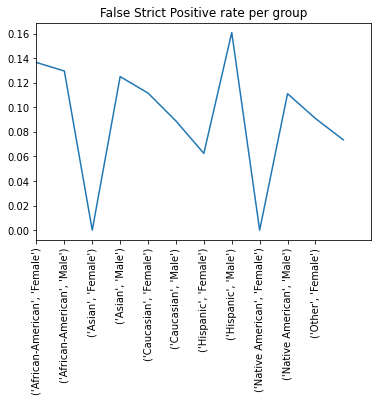

In [17]:
keys=[]
acc_list=[]
for key, item in stat:
    keys.append(key)
    stat_group=stat.get_group(key)
    FPos=stat_group[(((df.score_text=='High')) & (stat_group.two_year_recid==0))].count()['score_text']
    Pos=stat_group[((df.score_text=='High') | (df.score_text=='Medium'))].count()['score_text']
    if FPos==0 :
        accurecy = 0
    else:
        accurecy=FPos/Pos
    print(key,'\n',accurecy, '\n\n')
    acc_list.append(accurecy)

plt.plot(acc_list)
plt.xlim(0,12)
plt.xticks(range(0, 11),keys,rotation=90)
plt.title("False Strict Positive rate per group")




Here, by only look at the *High* score category, we can see that *African-American* has a higher false positive rate than other races, and the *'Hispanic', 'Male'* group has the highest false positive rate overall. This means the model categorises the previously mentioned gender race combination at a higher risk than it is in reality.

('African-American', 'Female') 
 0.23492063492063492 


('African-American', 'Male') 
 0.37945318972659486 


('Asian', 'Female') 
 0.5 


('Asian', 'Male') 
 0.09090909090909091 


('Caucasian', 'Female') 
 0.25072886297376096 


('Caucasian', 'Male') 
 0.29832935560859186 


('Hispanic', 'Female') 
 0.27586206896551724 


('Hispanic', 'Male') 
 0.2916666666666667 


('Native American', 'Female') 
 0 


('Native American', 'Male') 
 0.2 


('Other', 'Female') 
 0.17857142857142858 


('Other', 'Male') 
 0.3305785123966942 




Text(0.5, 1.0, 'True Nagative rate per group')

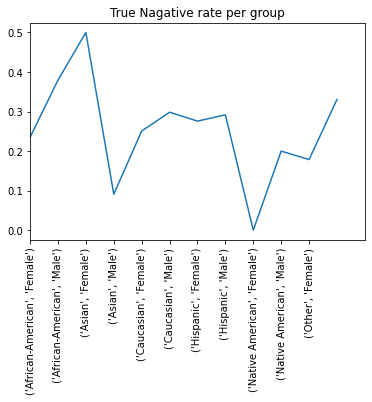

In [18]:
keys=[]
acc_list=[]
for key, item in stat:
    keys.append(key)
    stat_group=stat.get_group(key)
    FNeg=stat_group[((stat_group.score_text=='Low') & (stat_group.two_year_recid==1))].count()['score_text']
    Neg=stat_group[(stat_group.score_text=='Low')].count()['score_text']
    if FNeg==0 :
        accurecy = 0
    else:
        accurecy=FNeg/Neg
    print(key,'\n',accurecy, '\n\n')
    acc_list.append(accurecy)

plt.plot(acc_list)
plt.xlim(0,12)
plt.xticks(range(0, 11),keys,rotation=90)
plt.title("True Nagative rate per group")

## Part Twe: Standard classifiers

### Preparing the data:

To make a classifier it is required that we first choose which features of the data set will act as input.
We choose for the next features:

*sex, age, race, juv_fel_count, juv_misd_count, juv_other_count, priors_count, days_b_screening_arrest, c_jail_in, c_jail_out , c_days_from_compas, c_charge_degree, in_custody, out_custody and priors_count*.

All relate to the person prior to their second crime, if there was one.
We adopted these since they represented the criminal defendants well and because they can have influence on future crime.
Likewise we assume that other features like _id_ or *c_case_number* are independent of future crimes.

Before these features can act as input to a classifier, the data will first have to be manipulated.
For example *c_jail_in* and *c_jail_out* are transformed to a new column *jail_time*, that is; the amount of day spend in jail. In the same manner *custody_time* is defined by *in_custody*  and *out_custody*.
When the defendant has not spend any time in jail or custody, then *jail_time* or *custody_time* will be 0.

In [20]:
#df = df.dropna(subset=["days_b_screening_arrest"]) #TODO remove

# Fill in NAN with 0, such that the diffence in date will be 0.
df['c_jail_in'].fillna(0)
df['c_jail_out'].fillna(0)
df['in_custody'].fillna(0)
df['out_custody'].fillna(0)

length =len(df['race'])

df = df.assign(jail_time=pd.Series(np.random.randn(length)).values)
df['jail_time'] = (df['c_jail_out'].apply(pd.Timestamp) - df['c_jail_in'].apply(pd.Timestamp)).dt.days

df = df.assign(custody_time=pd.Series(np.random.randn(length)).values)
df['custody_time'] = (df['out_custody'].apply(pd.Timestamp) - df['in_custody'].apply(pd.Timestamp)).dt.days

Further some feature are expresed in strings and not number. Hence we transfer them, such that; the classifier can have them as input.

In [21]:
df['sex'].replace({'Male': 0, 'Female': 1}, inplace= True)
df['race'].replace({'African-American':0, 'Caucasian':1, 'Hispanic':2, 'Other':3, 'Asian':4, 'Native American':5}, inplace= True)
df['c_charge_degree'].replace({'F':0, 'M':1}, inplace= True)

Now we can collect the features and normalise them, because the range of possible values is different. Of course the label of the samples will be the recidivism within two years.

In [22]:
X = df[['sex', 'age', 'race', 'juv_fel_count', 'juv_misd_count', 'juv_other_count',
        'priors_count', 'days_b_screening_arrest', 'jail_time', 'c_days_from_compas', 'c_charge_degree', 'custody_time', 'priors_count']]
y = df['two_year_recid']  # Ground thruth whether they will recommit a crime or not.
print(X.head(1))

# Normalise X between [0, 1]/
X_np = X.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X_np)
X = pd.DataFrame(X_scaled)
print(X.head(1))

   sex  age  race  juv_fel_count  juv_misd_count  juv_other_count  \
0    0   69     3              0               0                0   

   priors_count  days_b_screening_arrest  jail_time  c_days_from_compas  \
0             0                     -1.0          0                 1.0   

   c_charge_degree  custody_time  priors_count  
0                0             7             0  
     0         1    2    3    4    5    6         7        8         9   10  \
0  0.0  0.653846  0.6  0.0  0.0  0.0  0.0  0.280761  0.00125  0.000105  0.0   

        11   12  
0  0.00116  0.0  


### Classifiers
Several classifiers will be proposed in the next section.
Every time a simple evalution performance in terms of accuracy is mentioned.

In [23]:
def accuracy(y_test, y_model):
    acc = accuracy_score(y_test, y_model)
    print('Accuracy of the network on the test samples: ' + str(acc))
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #20 procent test set

#### Gaussian Naive Bayes

In [24]:
model = GaussianNB()
model.fit(X_train, y_train)
y_model = model.predict(X_test)

accuracy(y_test, y_model)

Accuracy of the network on the test samples: 0.6005788712011577


#### K-Nearest Neighbours
By increasing the number of neighbours the accuracy increases. Yet at a certain point every entry might be classified as the most probable class in the entire dataset, because k is so large. Resulting in a negative effect on the accuracy. We dicovered that this occurs when k is 55.

In [25]:
model = KNeighborsClassifier(n_neighbors=55)
model.fit(X_train, y_train)
y_model = model.predict(X_test)

accuracy(y_test, y_model)

Accuracy of the network on the test samples: 0.6657018813314037


#### Multi Layer Perceptron
A multi layer perceptron (MLP) appeared to have a better accuracy when there are more nodes in the hidden layers and when using relu as teh activation function.

In [26]:
classifier = MLPClassifier(hidden_layer_sizes=(150,100,50), activation='relu', solver='adam', max_iter=2000)
classifier.fit(X_train, y_train)
y_model = classifier.predict(X_test)

accuracy(y_test, y_model)

Accuracy of the network on the test samples: 0.6903039073806078


#### Linear Regression
Linear regression required to round the output in order to still have a binary classifier. This model definedly performed very good in terms of accuracy.

In [27]:
model = LinearRegression(fit_intercept=True)
model.fit(X_train, y_train)
y_model = (model.predict(X_test)).round()

accuracy(y_test, y_model)

Accuracy of the network on the test samples: 0.670767004341534


#### Neural Network with dense layers.

An other classifier is a neural network existing out of three dense layers using the relu activation function.
At the end of the network a sigoid function is applied.

To train this network, we add a dimension to the *X_train* and *X_test* and turn our training and test sets to tensors. Further we create the dataloaders *trainloader* and *testloader* to iterate easily over the dataset during training.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #20 procent test set

X_train = torch.from_numpy(X_train.to_numpy()).float()
X_train.unsqueeze_(1)
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())

dataset_train = dt.TensorDataset(X_train, y_train)
trainloader = dt.DataLoader(dataset_train, batch_size=5, shuffle=True, num_workers=2) # Let the amount of training samples be dividable by the batch size 


X_test = torch.from_numpy(X_test.to_numpy()).float()
X_test.unsqueeze_(1)
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

dataset_test = dt.TensorDataset(X_test, y_test)
testloader = dt.DataLoader(dataset_test, batch_size=5, shuffle=True, num_workers=2)


print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([5525, 1, 13]) torch.Size([5525])
torch.Size([1382, 1, 13]) torch.Size([1382])


In [29]:
class Net_dense(nn.Module):

    def __init__(self, n_features):
        super(Net_dense, self).__init__()
        self.fc1 = nn.Linear(n_features, 8)
        self.fc2 = nn.Linear(8, 5)
        self.fc3 = nn.Linear(5, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return torch.sigmoid(self.fc3(x))
net_dense = Net_dense(X_train.shape[2])
print(net_dense)


Net_dense(
  (fc1): Linear(in_features=13, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=5, bias=True)
  (fc3): Linear(in_features=5, out_features=1, bias=True)
)


Furthermore the learning rate is 0.001 and the loss fuction is the Binary Cross Entropy.
The following functions allow to train the given network and to predict the labels of the test set. Then we train the network and compute the accuracy.

In [30]:
criterion_dense = nn.BCELoss()
optimizer_dense = optim.SGD(net_dense.parameters(), lr=0.001, momentum=0.9)

In [31]:
def train(trainloader, net, criterion, optimizer):
    for epoch in range(1):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # print statistics
            running_loss += loss.item()
            if i % 99 == 0:    # print every 100 mini-batches of 4 trainling examples
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0    

In [32]:
def predict (net, testloader):
    y_pred_list = []
    with torch.no_grad():
        for data in testloader:
            samples, labels = data
            y_test_pred = net(samples)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.numpy())
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_model = [item for sublist in y_pred_list for item in sublist]
    return y_model    

In [33]:
train(trainloader, net_dense, criterion_dense, optimizer_dense)

/home/simon_rober/.local/lib/python3.6/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[1,     1] loss: 0.000
[1,   100] loss: 0.034
[1,   199] loss: 0.034
[1,   298] loss: 0.034
[1,   397] loss: 0.034
[1,   496] loss: 0.034
[1,   595] loss: 0.034
[1,   694] loss: 0.034
[1,   793] loss: 0.034
[1,   892] loss: 0.034
[1,   991] loss: 0.034
[1,  1090] loss: 0.034


In [34]:
y_model = predict (net_dense, testloader)
accuracy(y_test, y_model)

Accuracy of the network on the test samples: 0.5332850940665702


#### CNN

Further we try a Convolutional Neural Network. The CNN is not the best solution to the problem, since there are only a few features and each convolution layer reduces the amount of features incredibly. Because of this problem the kernel_size cannot be further increased, resulting in a poor accuracy.

In [35]:
class Net_CNN(nn.Module):

    def __init__(self, n_features):
        super(Net_CNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=2,stride=1, padding=0)
        self.conv2 = nn.Conv1d(16, 64, kernel_size=2,stride=1, padding=0)
        self.fc1 = nn.Linear(128, 64)       # Dense / Fully connnected layer.
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
        
    def forward(self, x):
        x = F.max_pool1d(F.relu(self.conv1(x)), kernel_size=2)
        x = F.max_pool1d(F.relu(self.conv2(x)), kernel_size=2)
        x = x.view(-1, self.num_flat_features(x))               # Flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x
    
net_CNN = Net_CNN(X_train.shape[1])
print(net_CNN)

Net_CNN(
  (conv1): Conv1d(1, 16, kernel_size=(2,), stride=(1,))
  (conv2): Conv1d(16, 64, kernel_size=(2,), stride=(1,))
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)


In [36]:
criterion_cnn = nn.BCELoss()
optimizer_cnn = optim.SGD(net_CNN.parameters(), lr=0.001, momentum=0.9)

In [37]:
train(trainloader, net_CNN, criterion_cnn, optimizer_cnn)

/home/simon_rober/.local/lib/python3.6/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[1,     1] loss: 0.000
[1,   100] loss: 0.034
[1,   199] loss: 0.034
[1,   298] loss: 0.034
[1,   397] loss: 0.034
[1,   496] loss: 0.034
[1,   595] loss: 0.034
[1,   694] loss: 0.034
[1,   793] loss: 0.034
[1,   892] loss: 0.034
[1,   991] loss: 0.034
[1,  1090] loss: 0.034


In [38]:
y_model = predict (net_CNN, testloader)
accuracy(y_test, y_model)

Accuracy of the network on the test samples: 0.5332850940665702


### Compas Accuracy
The given dataset provides a *decile_score* and a *score_text*. Both are multiclass labels on the criminal defendants assigned by Compas or Propublica. In order to compare the accuracy of the Compas classifier with  our classifiers, the compass classifier has to be a binary. Further, the Compas files make it clear that each defendant with a _Medium_ or *High score_text* is classified as being recid and the others with a *Low score\_text* as not recid. Hence we will append a new column *comp_bin_clas* to the datafram, that represents the classification of the compas binary classifier.

In [39]:
df = df.assign(comp_bin_clas=pd.Series(np.random.randn(length)).values)

def deduct_bin_score_comp(row):
    if (row['score_text'] == "Medium" or row['score_text'] == "High"):
        return 1
    if row['score_text'] == "Low":
        return 0
    return -1

df['comp_bin_clas'] = df.apply (lambda row: deduct_bin_score_comp(row), axis=1)

Given the ground truth of *two_year_recid* and the binary classification *comp_bin_clas* we compute the accuracy of the binary classifier.

In [40]:
def comp_acc_Compass(df):
    df_temp = df.apply(lambda row: True if row['two_year_recid'] == 1 and row['comp_bin_clas'] == 1 else False , axis=1)
    tp = len(df_temp[df_temp == True].index)
    
    df_temp = df.apply(lambda row: True if row['two_year_recid'] == 1 and row['comp_bin_clas'] == 0 else False , axis=1)
    fn = len(df_temp[df_temp == True].index)
    
    df_temp = df.apply(lambda row: True if row['two_year_recid'] == 0 and row['comp_bin_clas'] == 1 else False , axis=1)
    fp = len(df_temp[df_temp == True].index)
    
    df_temp = df.apply(lambda row: True if row['two_year_recid'] == 0 and row['comp_bin_clas'] == 0 else False , axis=1)
    tn = len(df_temp[df_temp == True].index)
    
    return (tp + tn) / (tp + tn + fp + fn)

compass_accuarcy = comp_acc_Compass(df)
print('Accuracy of the Compas binary classifier: ' + str(compass_accuarcy))

Accuracy of the Compas binary classifier: 0.6597654553351672


### Comparison

The table below summarises the accuracies for each classifier.

| **Classifier**       | **Accuracy**     |
| :------------- | :----------: |
|  Gaussian Naive Bayes | 0.6005788712011577  |
| K-Nearest Neighbours   | 0.6657018813314037 |
| Multi Layer Percerptron |  0.6490593342981187  |
|  Linear Regression | 0.670767004341534  |
|  Dense Neural Network | 0.5332850940665702 |
|  Convolutional Neural Network | 0.5332850940665702 |
|  Compas Binary Classifier  |  0.6597654553351672 |

Linear Regression show the best performance and hence is our preference and recommendation followed by the K-Nearest Neighbours.
Both outperform the binary Compass classifier.
Finally a remarkable result occurs with both Neural networks. They appear to have hit the same ceiling in performance. Finally we dicovered that the CNN is remarkably slower then the Neural network during training. This is due to the convolytional layes that require a lot of computation power.